1. This tutorial is that I give some hand-written images to the neural network(Convolutional Neural Network) as input.
2. The neural network extracts the features on the convolution layers
3. The output is classified by the dense layers
4. We can define Categorical Crossentropy loss by the prediction and ground-truth
5. So, our goal is to minimize the loss by the optimizer
6. Finally, the cnn can predict the label of the input image, correctly.

# Import libraries

In [1]:
import tensorflow as tf # Deeplearning packages

import warnings
warnings.filterwarnings(action='ignore')

print("The version of packages")
print(tf.__version__)

The version of packages
2.0.0


# Data load & Pre-processing function
- Expand channel dimension for convolutional computation.
- Raw Mnist data is 0 ~ 255.
- It means the variance is big.
- So normalize it by dividing 255

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical # make one-hot vector

def load_mnist():
    (train_data, train_labels), (test_data, test_labels) = mnist.load_data()
    train_data = np.expand_dims(train_data, axis = -1) # (60000, 28, 28) -> (60000, 28, 28, 1)
    test_data = np.expand_dims(test_data, axis = -1) # (10000, 28, 28) -> (10000, 28, 28, 1) 
    
    train_data, test_data = normalize(train_data, test_data)
    
    train_labels = to_categorical(train_labels) # (n,) -> (n,10)
    test_labels = to_categorical(test_labels) # (n,) -> (n,10)
    
    return train_data, train_labels, test_data, test_labels

def normalize(train_data, test_data):
    train_data = train_data.astype(np.float32) / 255.
    test_data = test_data.astype(np.float32) / 225.
    
    return train_data, test_data


# Data Example
- Because input data is matrix form, I import numpy package.
- To visualize the input matrix as image, I need matplotlib library

Train_data shape is: (60000, 28, 28, 1)
Train_label shape is: (60000, 10)



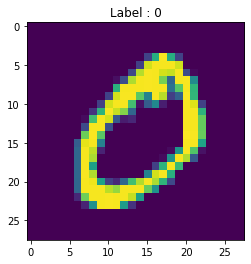

In [3]:
import matplotlib.pyplot as plt # To visualize the input images
import numpy as np
%matplotlib inline

train_data, train_labels, test_data, test_labels = load_mnist()
print('Train_data shape is:',train_data.shape)
print('Train_label shape is:',train_labels.shape)
print()
idx = np.random.randint(0, 10)

plt.imshow(train_data[idx].reshape(28,28))
plt.title("Label : %d"%np.where(train_labels[idx]==1)[0][0])
plt.show()

# Create Model( Dense Net )
- https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- Convolution is for feature extraction
- Dense is for classifing the input data

In [4]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

input_shape = train_data.shape[1:] # (28, 28, 1)

def Conv_net(input_shape = input_shape):
    
    model = Sequential([
        
        # Feature Extract part
        Conv2D(filters=32, kernel_size = 3, padding='SAME', activation = 'relu', input_shape=input_shape), # (28, 28, 1) -> (28, 28, 32)
        MaxPooling2D(padding='SAME'), # (14, 14, 32), default pool size is [2,2]

        Conv2D(filters=64, kernel_size = 3, padding='SAME', activation = 'relu'), # (14, 14, 32) -> (14, 14, 64)
        MaxPooling2D(padding='SAME'), # (7, 7, 64)

        Flatten(), # (7, 7, 32) -> (7*7*64)

        # Classfication part
        Dense(units=1024, activation='relu'), # (3136,) -> (1024,)
        Dropout(0.2), # Model Regularization for generalization ny drop the edges

        Dense(units=128, activation='relu'), # (1024,) -> (128,)
        Dropout(0.2),

        Dense(units=10, activation='softmax') # 
        
    ])
    
    return model

model = Conv_net(input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3212288   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

# Loss & Optimizer
- Categorical_crossentropy https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy
- Optimizer(gradient descent algorithm) https://ruder.io/optimizing-gradient-descent/

In [5]:
lr=0.001

loss = tf.keras.losses.categorical_crossentropy
sgd = tf.keras.optimizers.SGD(learning_rate=lr)

model.compile(loss = loss,
              optimizer = sgd,
              metrics= ['accuracy'])

# Data Pipeline

In [6]:
from sklearn.model_selection import train_test_split

test_idx, val_idx = train_test_split(list(range(10000)), test_size = 0.5)

In [7]:
def make_dataset(data, labels, shuffle, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size = data.shape[0])
    
    dataset = dataset.batch(batch_size)
    
    return dataset
    

buffer_size = train_data.shape[0]
batch_size = 100

train_ds = make_dataset(train_data,train_labels,True, batch_size)
val_ds = make_dataset(test_data[val_idx],test_labels[val_idx],False, batch_size)
test_ds = make_dataset(test_data[test_idx],test_labels[test_idx],False, batch_size)

# Train

In [8]:
epochs = 10

hist = model.fit(
    train_ds,
    epochs=epochs,
    validation_data= val_ds
)

Epoch 1/10
600/600 [==============================] - 38s 63ms/step - loss: 2.2720 - accuracy: 0.2218 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 37s 62ms/step - loss: 2.1519 - accuracy: 0.3963 - val_loss: 1.9642 - val_accuracy: 0.6014
Epoch 3/10
600/600 [==============================] - 37s 62ms/step - loss: 1.7409 - accuracy: 0.5616 - val_loss: 1.1640 - val_accuracy: 0.7590
Epoch 4/10
600/600 [==============================] - 37s 62ms/step - loss: 1.0625 - accuracy: 0.6980 - val_loss: 0.6081 - val_accuracy: 0.8446
Epoch 5/10
600/600 [==============================] - 37s 62ms/step - loss: 0.7237 - accuracy: 0.7786 - val_loss: 0.4328 - val_accuracy: 0.8854
Epoch 6/10
600/600 [==============================] - 37s 62ms/step - loss: 0.5691 - accuracy: 0.8253 - val_loss: 0.3645 - val_accuracy: 0.8982
Epoch 7/10
600/600 [==============================] - 37s 62ms/step - loss: 0.4894 - accuracy: 0.8492 - val_loss: 0.3196 - val_a

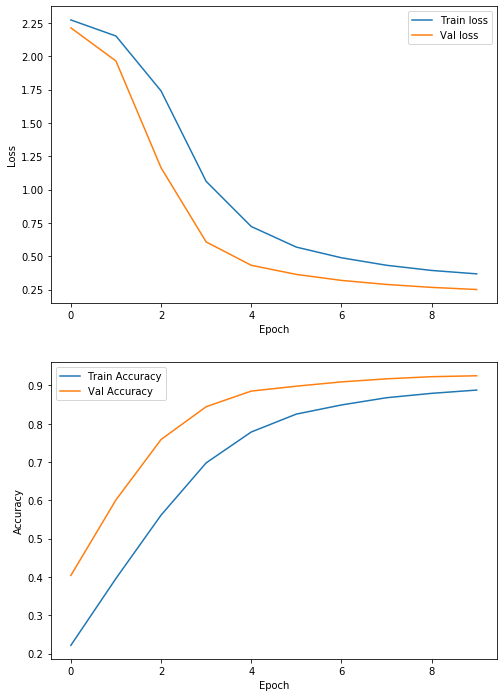

In [9]:
import pandas as pd

# Previous Unfiltered Data 'MSE' And 'MAE'
def plot_history(history, idx):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'][idx:], hist['loss'][idx:],
           label='Train loss')
    plt.plot(hist['epoch'][idx:], hist['val_loss'][idx:],
           label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'][idx:], hist['accuracy'][idx:],
           label='Train Accuracy')
    plt.plot(hist['epoch'][idx:], hist['val_accuracy'][idx:],
           label = 'Val Accuracy')
    plt.legend()
    plt.show()
    
plot_history(hist,0)

# Evaluate Model by using test_ds

In [10]:
loss, accuracy = model.evaluate(test_ds)
print("Loss is", loss, "\nAccuracy is", accuracy)

50/50 [==============================] - 1s 11ms/step - loss: 0.2616 - accuracy: 0.9208
Loss is 0.2615948134660721 
Accuracy is 0.9208


# Save the Model

In [11]:
model.save('./models/mnist_classification.h5')

# Load the model parameter
- Only the same architecture

In [13]:
model2 = Conv_net(input_shape)
model2.load_weights('./models/mnist_classification.h5')

model2.compile(loss='categorical_crossentropy',
             optimize = sgd,
              metrics=['accuracy'])
loss, accuracy = model2.evaluate(test_ds)
print("Loss is", loss, "\nAccuracy is", accuracy)

50/50 [==============================] - 1s 13ms/step - loss: 0.2616 - accuracy: 0.9208
Loss is 0.2615948134660721 
Accuracy is 0.9208
